<a href="https://colab.research.google.com/github/JhanXXX/AI-in-Transport-TTGTM/blob/main/Assignment%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this assignment, I didn't set a fixed random seed because I plan to rerun the parameter settings multiple times to see if the model performs stably.
Since the dataset is already cleaned and well-structured before, I didn't look deep into the data itself, but tried out several plans to construct and re-structure the neural network.

More specifically: I have tried adding layers (like dense layer, drop layer with different drop rate), and L2 regularization, learning rate from 0.0001-0.001, etc. I also tried adjusting the batch size to see what would happen.
Also because this dataset is already well processed, I didn't find any of the methods I tried really greatly improved the prediction precisity. Yet it is very interesting and inspiring trying out different settings and see what effects will be caused.

Moreover, I am also wondering whether it is actually a normally acceptable phenomenon that the model performs quite differently each time rerunning. Considering fixing the random seed, this time parameter sets A is better than B, which is not exactly true because when the random seed changes, B can be better than A sometimes. To explore this point, I asked ChatGPT and the response was negative, that: *It is not typically acceptable for a well-trained model to show significantly different performance every time you rerun the code, especially with the same hyperparameters and dataset. While minor fluctuations are normal due to stochastic elements in training (such as random initialization and data shuffling), large variations in performance usually indicate underlying issues with the model, data, or training process.*


Current dataset may not be able to support digging into this problem more but still interesting to think about it.

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from sklearn.linear_model import LinearRegression
filepath=""


url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_7_Neural_networks/Exercise7data.csv'

# Read the CSV data from the specified URL into a DataFrame (assuming you have the pandas library imported as 'pd').
df = pd.read_csv(url)

# Limit the DataFrame to the first 1000 rows (selecting a subset of the data).
df = df.iloc[:1000]

# Drop specific columns (Arrival_time, Stop_id, Bus_id, Line_id) from the DataFrame.
df = df.drop(['Arrival_time', 'Stop_id', 'Bus_id', 'Line_id'], axis=1)

# Extract the features (input variables) by dropping the 'Arrival_delay' column.
x = df.drop(['Arrival_delay'], axis=1)

# Extract the target variable ('Arrival_delay') as the variable to predict.
y = df['Arrival_delay']

# splite the train and test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [35]:
# Model training function
# use the callback function to early stop, learning rate ajusting, save the best model
# Create an EarlyStopping callback to monitor the validation mean absolute error (val_mae).
# It will stop training if val_mae doesn't improve for 5 consecutive epochs and restores the best weights.

def trainmodel (model, X_train, y_train, test_epochs, test_batch_size):
  early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

# Create a ReduceLROnPlateau callback to monitor val_mae.
# It reduces the learning rate by a factor of 0.5 if val_mae doesn't improve for 3 consecutive epochs.
  reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

# Define the file path where the best model weights will be saved.
  filepath = "weights.best.keras"
# Create a ModelCheckpoint callback to monitor the validation mae (val_mae).
# The callback will save the model's weights only if the validation mae improves.
  checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Train the model using the fit method.
  hist = model.fit(X_train, y_train, validation_split=0.2, epochs=test_epochs, batch_size=test_batch_size, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)
  return hist, model

In [36]:
# Evaluation function
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Set the style of the plots using seaborn.
def evaluatemodel (hist, model):
  sns.set()

# Extract the training and validation Mean Absolute Error (MAE) from the training history.
  err = hist.history['mae']
  val_err = hist.history['val_mae']

# Define the number of epochs.
  epochs = range(1, len(err) + 1)

# Plot the Training MAE and Validation MAE over epochs.
  plt.plot(epochs, err, '-', label='Training MAE')
  plt.plot(epochs, val_err, ':', label='Validation MAE')
  plt.title('Training and Validation MAE')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.legend(loc='upper right')
  plt.plot()

# Use the trained model to predict on the test data.
  y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R2) for the predictions.
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics.
  print(f"Mean Absolute Error: {mae}")
  print(f"Mean Squared Error: {mse}")
  print(f"R-squared: {r2}")

In [37]:
# record the performance
class Records ():
  def __init__(self):
    self.log = []
    self.hist = None
    self.model = None
    self.mae = None
    self.mse = None
    self.r2 = None

In [40]:
# NN construction
# first try
record1 = Records()
record1.log.append("original solution")
# Create a Sequential model, which is a linear stack of layers.
model = Sequential()
# Add a Dense layer with 32 units, ReLU activation, and an input dimension of 4.
model.add(Input(shape=(4,)))
model.add(Dense(32, activation='relu'))
# Add another Dense layer with 64 units and ReLU activation.
model.add(Dense(64, activation='relu'))
# Add a final Dense layer with 1 unit (typically used for regression tasks).
model.add(Dense(1))
# Compile the model with the Adam optimizer, Mean Absolute Error (MAE) loss function,
# and MAE metric to be used during training.
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
test_epochs = 200
test_batch_size = 32

hist, model = trainmodel (model, X_train, y_train, test_epochs, test_batch_size)
record1.hist = hist
record1.model = model
model = None
hist = None


Epoch 1: val_mae improved from inf to 46.28711, saving model to weights.best.keras

Epoch 2: val_mae improved from 46.28711 to 37.81709, saving model to weights.best.keras

Epoch 3: val_mae improved from 37.81709 to 31.53027, saving model to weights.best.keras

Epoch 4: val_mae did not improve from 31.53027

Epoch 5: val_mae did not improve from 31.53027

Epoch 6: val_mae did not improve from 31.53027

Epoch 7: val_mae did not improve from 31.53027

Epoch 8: val_mae did not improve from 31.53027


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Mean Absolute Error: 27.926718373298645
Mean Squared Error: 1415.7059315601684
R-squared: 0.8800044655799866


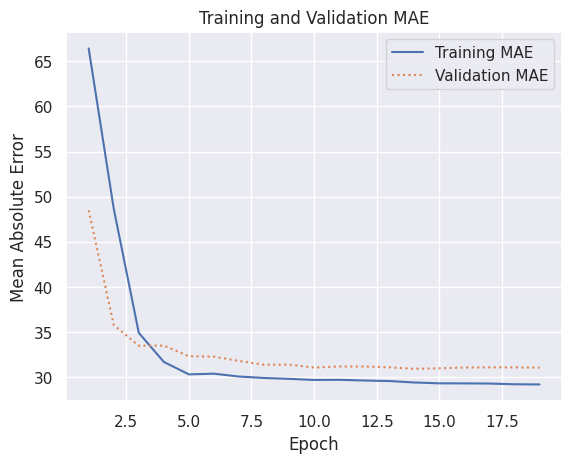

In [33]:
evaluatemodel (record1.hist, record1.model)

I reran several times the provided code. The results appeared to be very irregularly fluctuating. Above is one of the worsest situation. The validation was a mess.

In [ ]:
# NN construction
# second try
# Here try adjusting the learning rate to see the influence
from keras.optimizers import Adam
model = None
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=['mae'])
test_epochs = 200
test_batch_size = 32


Epoch 1: val_mae improved from inf to 31.44742, saving model to weights.best.keras

Epoch 2: val_mae did not improve from 31.44742

Epoch 3: val_mae did not improve from 31.44742

Epoch 4: val_mae did not improve from 31.44742

Epoch 5: val_mae did not improve from 31.44742

Epoch 6: val_mae did not improve from 31.44742
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Absolute Error: 31.895551909208297
Mean Squared Error: 1793.241690087842
R-squared: 0.8480044603347778


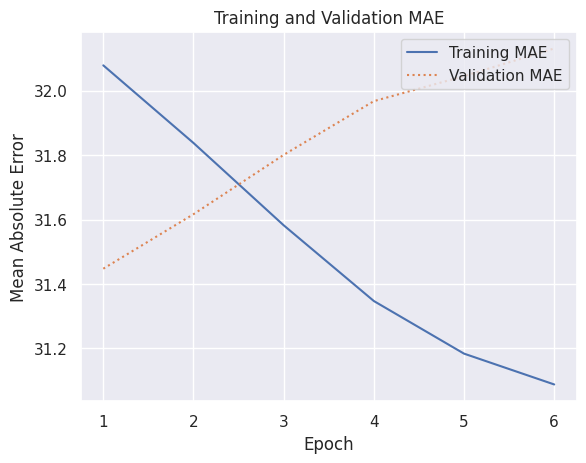

In [ ]:
hist, model = trainmodel (model, X_train, y_train, test_epochs, test_batch_size)
evaluatemodel (hist, model)

In [ ]:
# after tried several learning rates, from 0.001-0.0001, though each time the index
# wasnt completely the same, even with the same parameters
# the curve can hardly break through the value of 30 for MAE
# sometimes it is also a mess... (as shown above)

In [ ]:
# third try: adjust the model layers
model = None
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
test_epochs = 200
test_batch_size = 32


Epoch 1: val_mae improved from inf to 30.97678, saving model to weights.best.keras

Epoch 2: val_mae did not improve from 30.97678

Epoch 3: val_mae did not improve from 30.97678

Epoch 4: val_mae did not improve from 30.97678

Epoch 5: val_mae did not improve from 30.97678

Epoch 6: val_mae did not improve from 30.97678
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Absolute Error: 27.585724067687988
Mean Squared Error: 1393.66313305012
R-squared: 0.881872832775116


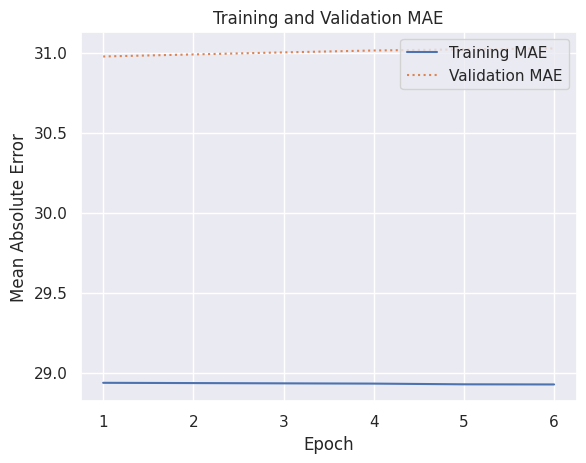

In [ ]:
hist, model = trainmodel (model, X_train, y_train, test_epochs, test_batch_size)
evaluatemodel (hist, model)

In [ ]:
# as shown above, not much improved
# however, this time the training was more steady during multiple repeatings
# yet the value of MAE is floating around 30

# with the original parameters set, try out adjusting the batch size again


Epoch 1: val_mae improved from inf to 46.86912, saving model to weights.best.keras

Epoch 2: val_mae improved from 46.86912 to 35.92146, saving model to weights.best.keras

Epoch 3: val_mae improved from 35.92146 to 33.24215, saving model to weights.best.keras

Epoch 4: val_mae did not improve from 33.24215

Epoch 5: val_mae improved from 33.24215 to 32.67949, saving model to weights.best.keras

Epoch 6: val_mae improved from 32.67949 to 32.59335, saving model to weights.best.keras

Epoch 7: val_mae improved from 32.59335 to 32.40244, saving model to weights.best.keras

Epoch 8: val_mae improved from 32.40244 to 32.37699, saving model to weights.best.keras

Epoch 9: val_mae improved from 32.37699 to 32.14040, saving model to weights.best.keras

Epoch 10: val_mae improved from 32.14040 to 31.92292, saving model to weights.best.keras

Epoch 11: val_mae did not improve from 31.92292

Epoch 12: val_mae did not improve from 31.92292

Epoch 13: val_mae improved from 31.92292 to 31.80417, sa

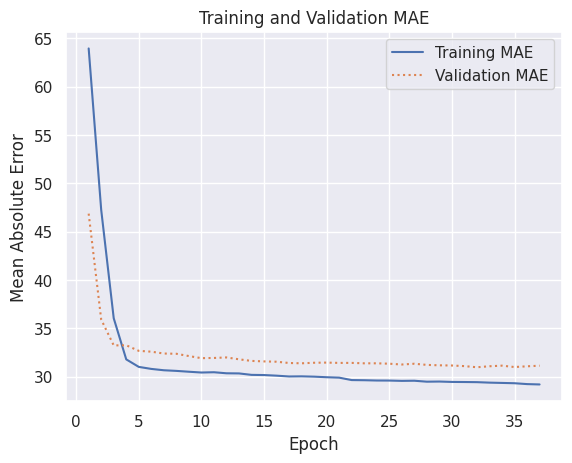

In [ ]:
model = None
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
test_epochs = 200
test_batch_size = 16
hist, model = trainmodel (model, X_train, y_train, test_epochs, test_batch_size)
evaluatemodel (hist, model)


Epoch 1: val_mae improved from inf to 45.19016, saving model to weights.best.keras

Epoch 2: val_mae improved from 45.19016 to 42.17646, saving model to weights.best.keras

Epoch 3: val_mae improved from 42.17646 to 38.19533, saving model to weights.best.keras

Epoch 4: val_mae improved from 38.19533 to 35.89540, saving model to weights.best.keras

Epoch 5: val_mae improved from 35.89540 to 33.23700, saving model to weights.best.keras

Epoch 6: val_mae improved from 33.23700 to 32.96976, saving model to weights.best.keras

Epoch 7: val_mae did not improve from 32.96976

Epoch 8: val_mae did not improve from 32.96976

Epoch 9: val_mae did not improve from 32.96976

Epoch 10: val_mae did not improve from 32.96976

Epoch 11: val_mae did not improve from 32.96976
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Mean Absolute Error: 34.19537451930344
Mean Squared Error: 2091.584648448585
R-squared: 0.8227168321609497


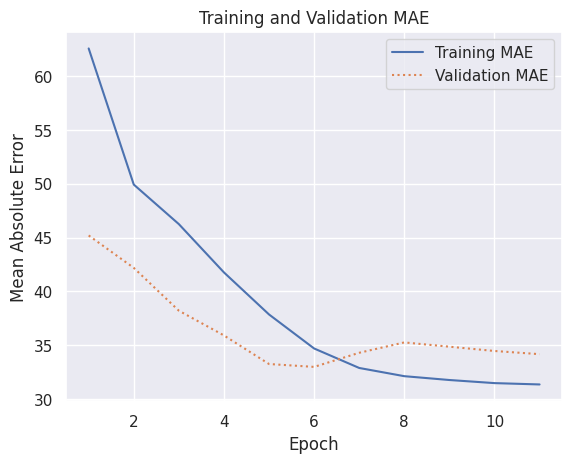

In [ ]:
model = None
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
test_epochs = 200
test_batch_size = 64
hist, model = trainmodel (model, X_train, y_train, test_epochs, test_batch_size)
evaluatemodel (hist, model)

In [ ]:
# still not much different
# the training time appears to be longer and the curve looks more "reasonable" though,
# showing a trend of convergence
# but when looking at the R-squared, the alignace of the dataset, is sometimes even worse.
# consider there might be overfitting
# try adding a dropout layer


Epoch 1: val_mae improved from inf to 51.04366, saving model to weights.best.keras

Epoch 2: val_mae improved from 51.04366 to 45.59319, saving model to weights.best.keras

Epoch 3: val_mae improved from 45.59319 to 41.19866, saving model to weights.best.keras

Epoch 4: val_mae improved from 41.19866 to 36.24833, saving model to weights.best.keras

Epoch 5: val_mae improved from 36.24833 to 34.12033, saving model to weights.best.keras

Epoch 6: val_mae improved from 34.12033 to 31.76131, saving model to weights.best.keras

Epoch 7: val_mae improved from 31.76131 to 30.65894, saving model to weights.best.keras

Epoch 8: val_mae improved from 30.65894 to 30.25032, saving model to weights.best.keras

Epoch 9: val_mae did not improve from 30.25032

Epoch 10: val_mae did not improve from 30.25032

Epoch 11: val_mae did not improve from 30.25032

Epoch 12: val_mae did not improve from 30.25032

Epoch 13: val_mae did not improve from 30.25032
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Mean Absolu

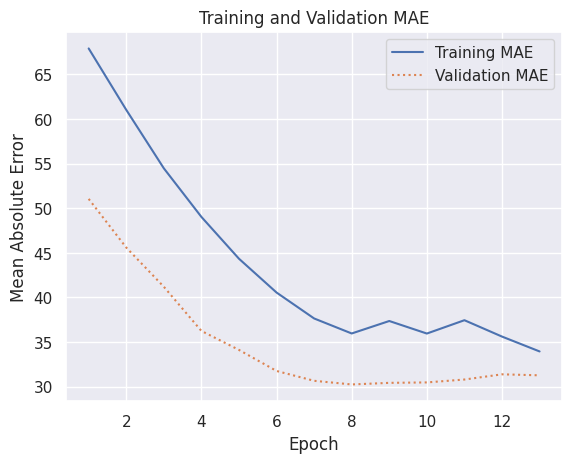

In [ ]:
from keras.layers import Dropout
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mae', metrics=['mae'])
test_epochs = 200
test_batch_size = 32

hist, model = trainmodel (model, X_train, y_train, test_epochs, test_batch_size)
evaluatemodel (hist, model)


Epoch 1: val_mae improved from inf to 39.36124, saving model to weights.best.keras

Epoch 2: val_mae improved from 39.36124 to 33.29016, saving model to weights.best.keras

Epoch 3: val_mae did not improve from 33.29016

Epoch 4: val_mae improved from 33.29016 to 31.85869, saving model to weights.best.keras

Epoch 5: val_mae improved from 31.85869 to 31.50781, saving model to weights.best.keras

Epoch 6: val_mae improved from 31.50781 to 31.30749, saving model to weights.best.keras

Epoch 7: val_mae improved from 31.30749 to 31.04354, saving model to weights.best.keras

Epoch 8: val_mae improved from 31.04354 to 30.58558, saving model to weights.best.keras

Epoch 9: val_mae improved from 30.58558 to 30.48780, saving model to weights.best.keras

Epoch 10: val_mae did not improve from 30.48780

Epoch 11: val_mae did not improve from 30.48780

Epoch 12: val_mae did not improve from 30.48780

Epoch 13: val_mae did not improve from 30.48780

Epoch 14: val_mae did not improve from 30.48780


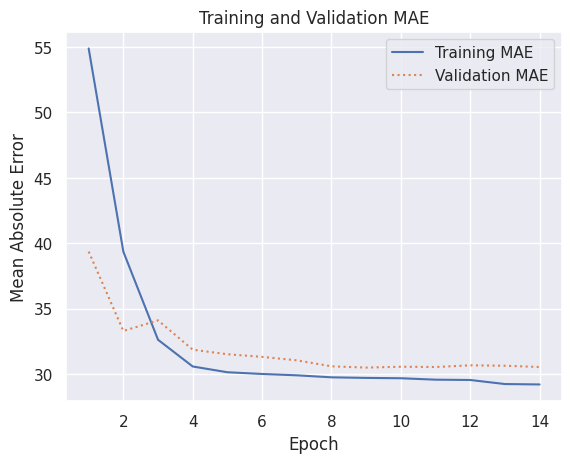

In [ ]:
from keras.regularizers import l2
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mae', metrics=['mae'])
test_epochs = 200
test_batch_size = 16

hist, model = trainmodel (model, X_train, y_train, test_epochs, test_batch_size)
evaluatemodel (hist, model)